In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyesg 
import  evaluation as eval
import preproccessing as prep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
acwi = pd.read_csv('acwi_25.08.23.csv',index_col='Date', parse_dates=True)
acwi = acwi.squeeze()
eurpln = prep.loadStooqData('eurpln','1998-12-01','d')
eurpln = eurpln.resample('MS').last()
acwi_pln = (acwi * eurpln).dropna()
acwi_pln_returns = prep.log_returns(acwi_pln)

<AxesSubplot:>

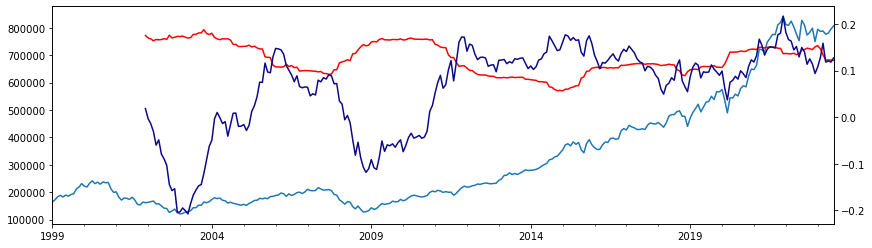

In [10]:
fig, ax1 = plt.subplots()
acwi_pln.plot(ax=ax1, figsize=(14,4))
ax2 = ax1.twinx()
(acwi_pln_returns.rolling(36).std()*np.sqrt(12)).plot(ax=ax2, colormap='autumn')
(acwi_pln_returns.rolling(36).mean()*12).plot(ax=ax2, colormap='plasma')

In [12]:
def asset_stats(returns, periods):
    summary = []

    for period in periods:
        summary.append(prep.assets_performance(returns[period[0]:period[1]]))

    return pd.DataFrame(data=summary, index=periods)

periods = [('1999-01-01', '2023-07-01'),
           ('2001-01-31', '2023-09-30'),
           ('2001-01-31', '2019-12-31'), 
           ('2000-08-31', '2023-07-31'),
           ('2003-03-31', '2020-03-31'),
           ('2003-03-31', '2022-12-31'),
           ('2009-02-28', '2022-12-31'),
           ('2007-10-31', '2022-12-31'),
           ('2007-10-31', '2015-05-30')
           ]


asset_stats(acwi_pln_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1999-01-01, 2023-07-01)",0.067608,0.132636,-0.483741,0.587445,0.982235,-0.499747
"(2001-01-31, 2023-09-30)",0.061700,0.130118,-0.485570,0.707671,0.843945,-0.409670
"(2001-01-31, 2019-12-31)",0.054627,0.128118,-0.639133,0.710926,0.665866,-0.409670
"(2000-08-31, 2023-07-31)",0.053389,0.131711,-0.511061,0.708356,0.615143,-0.487476
"(2003-03-31, 2020-03-31)",0.079022,0.119896,-0.531512,0.722272,1.416367,-0.409670
"(2003-03-31, 2022-12-31)",0.089588,0.122270,-0.325494,0.705576,1.688218,-0.409670
"(2009-02-28, 2022-12-31)",0.122844,0.112087,-0.155794,0.961303,2.869388,-0.148220
"(2007-10-31, 2022-12-31)",0.085245,0.127164,-0.405590,0.773284,1.504923,-0.333355
"(2007-10-31, 2015-05-30)",0.082170,0.123564,-0.891439,1.216516,1.462589,-0.333355


In [14]:

gbm_std = 0.133/np.sqrt(12)
gbm_mean = 0.5*gbm_std**2 + 0.068/12
print(gbm_mean)
print(gbm_std)

0.006403708333333334
0.03839379290111012


In [32]:
number_of_scenarios = 2000
number_of_steps = 300
model = pyesg.GeometricBrownianMotion(mu=gbm_mean,sigma=gbm_std)
scenarios = model.scenarios(100,1,number_of_scenarios,number_of_steps)
scenarios_df = pd.DataFrame(data=scenarios, index=range(0,number_of_scenarios), columns=range(0,number_of_steps+1))

Sample paths


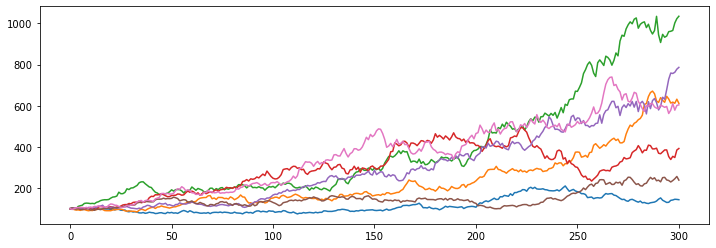

None
Fanchart


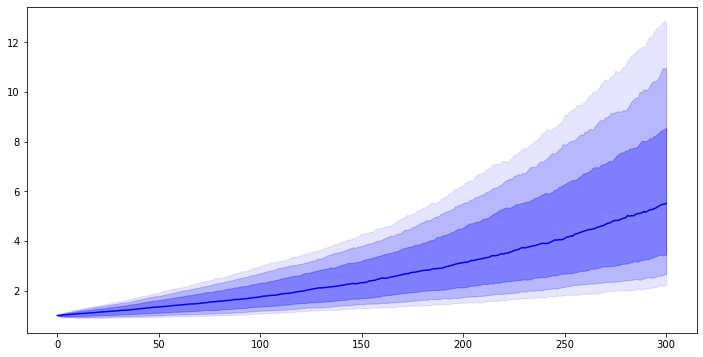

None
Percentaile summary


,12,36,60,120,240,300
10,0.905574,0.918486,0.963373,1.157218,1.741570,2.215243
15,0.935778,0.972651,1.035662,1.283764,2.047583,2.676736
25,0.982847,1.054287,1.151695,1.496365,2.531350,3.449532
50,1.078377,1.224478,1.421424,1.976376,3.894324,5.511460
75,1.182070,1.439540,1.750317,2.639083,5.910497,8.566827
85,1.238460,1.558426,1.965114,3.079468,7.232756,10.939386
90,1.277841,1.676229,2.102921,3.427398,8.368924,12.813570


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.067477,0.133030,0.000260,0.007814,0.976930,-0.317579
std,0.027476,0.005432,0.137295,0.281398,0.717024,0.088308
min,-0.023181,0.116650,-0.514794,-0.725029,-1.288684,-0.693359
25%,0.049530,0.129345,-0.092401,-0.190690,0.511200,-0.369218
50%,0.068273,0.132913,0.003741,-0.025775,0.995791,-0.304243
75%,0.085916,0.136725,0.092176,0.176416,1.456721,-0.251594
max,0.173209,0.150447,0.416598,1.207444,3.632831,-0.134203


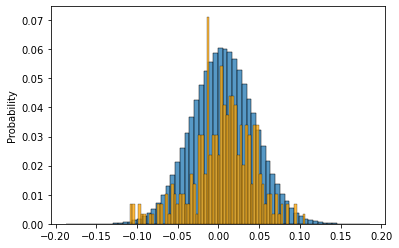

In [33]:
eval.show_scenarios_evaluation(scenarios_df,acwi_pln_returns)

In [34]:
import gbm_gibbs as gibs

sampler = gibs.GibsSamplerGBM(acwi_pln_returns['1999-01-01':'2023-07-31'],0.0064)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())


count    10001.000000
mean         0.067595
std          0.000963
min          0.000000
25%          0.067528
50%          0.067610
75%          0.067689
max          0.068141
Name: mu, dtype: float64
count    10001.000000
mean         0.187168
std          0.004577
min          0.000000
25%          0.184526
50%          0.187071
75%          0.189663
max          0.202752
Name: sigma, dtype: float64


Sample paths


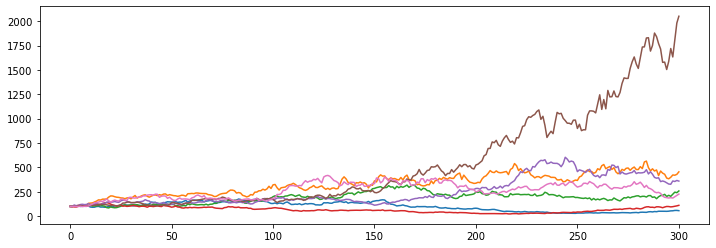

None
Fanchart


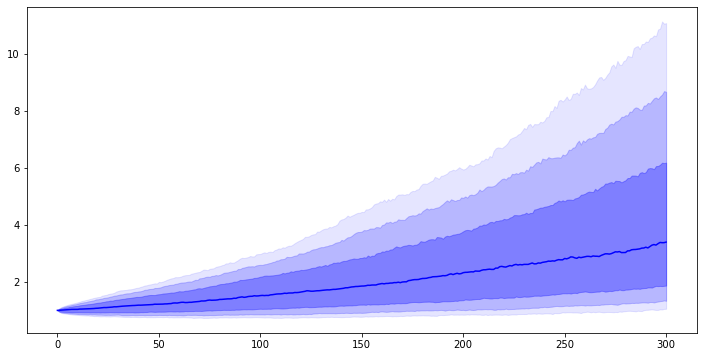

None
Percentaile summary


,12,36,60,120,240,300
10,0.826700,0.765767,0.753134,0.755558,0.893710,1.054701
15,0.871138,0.832160,0.834228,0.867999,1.124672,1.333657
25,0.929661,0.933175,0.957860,1.108850,1.527807,1.869744
50,1.045836,1.166761,1.268205,1.642310,2.695965,3.395201
75,1.185518,1.436921,1.672948,2.419862,4.634042,6.181895
85,1.268586,1.604646,1.959336,2.996648,6.302419,8.664781
90,1.328967,1.739288,2.167661,3.469502,7.648512,11.076895


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.048748,0.187125,-0.001804,0.006109,0.347757,-0.502329
std,0.037307,0.007710,0.142098,0.286139,0.692521,0.124750
min,-0.095837,0.163897,-0.489953,-0.709417,-2.498813,-0.911330
25%,0.025032,0.181793,-0.094577,-0.197329,-0.091769,-0.579904
50%,0.048894,0.186832,-0.003020,-0.022357,0.346898,-0.490368
75%,0.072865,0.192185,0.089195,0.166406,0.800749,-0.409873
max,0.164189,0.213866,0.559913,2.149766,2.437837,-0.205324


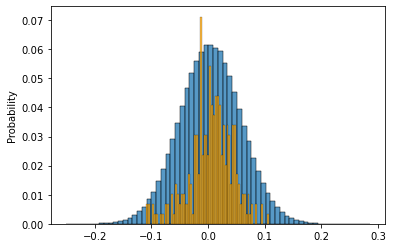

In [35]:
number_of_scenarios = 2000
number_of_steps = 300
model =pyesg.GeometricBrownianMotion(mu=np.percentile(mu,50),sigma=np.percentile(sig,50))
scenarios = model.scenarios(100,1,number_of_scenarios,number_of_steps)
scenarios_df = pd.DataFrame(data=scenarios, index=range(0,number_of_scenarios), columns=range(0,number_of_steps+1))
eval.show_scenarios_evaluation(scenarios_df,acwi_pln_returns)

In [62]:
acwi_level_price = pd.read_excel('msci_acwi_price_10.23.xlsx',index_col='Date')
acwi_p_returns = prep.log_returns(acwi_level_price)
acwi_p_returns.index = pd.DatetimeIndex(acwi_p_returns.index)

In [63]:
prep.assets_performance(acwi_p_returns)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
Price,0.05265,0.153876,-0.79517,1.989281,0.509904,-0.562312


In [65]:
acwi_p_returns = acwi_p_returns.loc["2001-01-01":]['Price']

In [66]:
prep.assets_performance(acwi_p_returns)

Annualised Mean     0.035918
Annualised Sigma    0.161218
Skew               -0.856279
Kurtosis            2.106301
Sharp_ratio         0.127165
Max drowdawn       -0.562312
dtype: float64

In [46]:
dividend = acwi_returns - acwi_p_returns

In [47]:
(dividend * 12).describe()

count    273.000000
mean       0.019091
std        0.008500
min        0.005466
25%        0.012378
50%        0.018444
75%        0.023922
max        0.049023
dtype: float64

In [60]:
ann_div = dividend.rolling(12).sum()